# Améliorer knn en utilisant l'algorithme d'arbre

Dans ce projet, nous nous intéressons aux différents moyens de recherche des k voisins plus proches d'un point X dans un jeu de données. 

In [1]:
from sklearn import datasets
from pprint import pprint
import pandas as pd
import timeit
from math import sqrt
import heapq
import numpy as np
import matplotlib.pyplot as plt

## Datasets

Nous allons exécuter nos programmes sur plusieurs jeu de données : Boston, Diabetes, Olivetti Faces. 

### Boston Dataset (Toy Dataset)

Pour ce jeu de données, nous allons travailler sur deux colonnes : 
- CRIM : Taux de criminalité par ville
- B : 1000(Bk - 0.63)^2 où Bk est la proportion de personne noir par ville


In [2]:
boston = datasets.load_boston()
boston_data = boston.data[:, [0, 11]].tolist()
boston_data_len = len(boston_data)
df_boston = pd.DataFrame(boston_data)
df_boston.describe()

,0,1
count,506.000000,506.000000
mean,3.613524,356.674032
std,8.601545,91.294864
min,0.006320,0.320000
25%,0.082045,375.377500
50%,0.256510,391.440000
75%,3.677083,396.225000
max,88.976200,396.900000


### Diabetes Dataset (Toy Dataset)

Pour ce jeu de données, nous allons travailler sur deux colonnes : 
- IMC : indice de masse corporel 
- s5 ltg, éventuellement log du taux de triglycérides sériques

In [3]:
diabetes = datasets.load_diabetes()
diabetes_data = diabetes.data[:, [2, 8]].tolist()
diabetes_data_len = len(diabetes_data)
df_diabetes = pd.DataFrame(diabetes_data)
df_diabetes.describe()

,0,1
count,4.420000e+02,4.420000e+02
mean,-8.045349e-16,-3.830854e-16
std,4.761905e-02,4.761905e-02
min,-9.027530e-02,-1.260974e-01
25%,-3.422907e-02,-3.324879e-02
50%,-7.283766e-03,-1.947634e-03
75%,3.124802e-02,3.243323e-02
max,1.705552e-01,1.335990e-01


### Olivetti Faces Dataset (Real World Dataset)

Pour ce jeu de données, nous allons travailler sur les deux premières colonnes. 

In [4]:
olivetti_faces = datasets.fetch_olivetti_faces()
olivetti_faces_data = olivetti_faces.data[:, :2]
olivetti_faces_data = olivetti_faces_data.tolist()
olivetti_faces_data_len = len(olivetti_faces_data)
df_olivetti_faces = pd.DataFrame(olivetti_faces_data)
df_olivetti_faces.describe()

,0,1
count,400.000000,400.000000
mean,0.400134,0.434236
std,0.180695,0.189504
min,0.086777,0.066116
25%,0.243802,0.267562
50%,0.392562,0.458678
75%,0.528926,0.575413
max,0.805785,0.822314


## K Nearest Neighbors

Ici, nous allons comparer deux manières de trouver les k voisins les plus proches : 
- Avec un arbre des médianes 
- D'une manière naïve

### Knn Kd-tree

En premier lieu, nous avons créé une fonction permettant d'obtenir un arbre afin d'optimiser les recherches. 
Pour cela nous calculons la médiane de notre jeu de données, préalablement trié, et séparons celui-ci en deux afin de créer deux feuilles: droite (points suppérieurs à la médiane) et gauche (points inférieurs à la médiane ainsi que la médiane). Nous exécutons ce processus sur chacunes des feuilles qui créées des jeux de données de plus en plus petit. Cet algorithme s'arrête une fois que le jeu de données ne contient qu'un point. 
Nous créons ainsi une liste contenant tous ces points que nous appelons kd_tree: elle contient chaque feuille de l'arbre.


In [5]:
def gen_kd_tree(data: list, col_index=0):
    next_col_index = 1 if col_index == 0 else 0
    if len(data) > 1:
        data.sort(key=lambda z: z[col_index])
        median_index = len(data) >> 1

        median_point = data[median_index]
        
        #split array at median point
        leaf_right = data[median_index + 1:]
        leaf_left = data[:median_index]
        
        return [
            median_point,
            gen_kd_tree(leaf_left, next_col_index),
            gen_kd_tree(leaf_right, next_col_index),
        ]
    elif len(data) == 1:
        return [data[0], None, None]

Dans un deuxième temps, nous cherchons les k voisins plus proches d'un point X et nous les mettons dans une nouvelle liste : nearest_neighbors. 
Pour construire nearest_neighbors, cette liste se remplit directement par les premiers points de la liste kd_tree, sans prendre en compte les calculs des distances que nous allons expliquer ensuite. Cependant notre liste des voisins est directement trié pour qu'on obtienne, dans l'ordre, la distance entre chaque point de kd_tree et X. De plus, cela s'arrêtera lorsque la liste (nearest_neighbors) aura atteint le nombre de voisins (k) souhaités. 

Pour chaque point, nous allons effectuer plusieurs calculs et manipulations : 
- En récupérant la liste des feuilles de l'arbre créé, nous calculons la distance euclidienne entre le point X et un point enregistré dans kd_tree. Ensuite, nous calculons la différence entre les x-coordinate (ou y-coordinate) du point et de X, selon le niveau de l'arbre (feuille impaire : x-coordinate et feuille paire : y-coordinate).

- Cela ne s'exécute uniquement après que nearest_neighbors est atteint la taille souhaitée (taille = k): 
    - Nous comparons les points enregistrés dans la liste des voisins par les résultats obtenus avec notre calcul des distances. Si la distance du nouveau point est plus petite que la distance maximale enregistrée dans nearest_neighbors, on remplace celle-ci par les données du même point (son point et sa distance avec X). 
    - Nous allons ensuite regarder si la distance maximale enregistrée dans nearest_neighbors est plus petite que la différence entre x/y-coordinate. Si c'est le cas, nous travaillons ensuite que sur la feuille gauche: donc uniquement la partie avant le point sur lequel on travaille. Si ce n'est pas le cas, nous travaillons sur les deux feuilles qui suivent car nous ne pouvons pas savoir quel point est le plus proche entre les deux points suivant. Nous faisons cela en suivant les branches de l'arbre.

Nous effectuons ainsi ces calculs avec tous les points de kd_tree. 

Une fois fini, nous changeons l'ordre nearest_neighbors qui, pour faciliter les manipulations, présentaient d'abord les distances avant les points. 
De ce fait, nearest_neighbors contient les k plus proches voisins de X. 

In [6]:
def find_knn(kd_tree, target_point, k, nearest_neighbors=None, z=0):
    next_z = 1 if z == 0 else 0

    # si nearest neighors vide -> source TRUE
    source = not nearest_neighbors

    #si TRUE -> créé une liste vide
    if source:
        nearest_neighbors = []
        
    #si kd_tree n'est pas nul
    if kd_tree:
        #calcul de la distance euclidienne et de la distance entre les x ou les y
        node = kd_tree[0]
        dist_e = distance(node, target_point)
        dist_xy = abs(node[z] - target_point[z])

        if len(nearest_neighbors) < k:
            #si nearest_neighbors toujours pas rempli 
            #-> continuer de rajouter les points dans la liste
            heapq.heappush(nearest_neighbors, (-dist_e, node))
        elif dist_e < -nearest_neighbors[0][0]:
            #si nearest_neighbors rempli 
            #-> comparer distance euclidienne des nouveaux points avec le point dans la liste qui a la plus grande distance euclidienne
            heapq.heappushpop(nearest_neighbors, (-dist_e, node))

        leaf_togo = [1, 2]
        if dist_xy > -nearest_neighbors[0][0]:
            #si distance entre les x ou les y est plus grande que la distance euclidiennede X et node 
            #-> aller uniquement à gauche sinon aller à gauche et droite
            del leaf_togo[1]
        
        #effectuer cette fonction sur les feuilles qui suivent 
        for i in leaf_togo:
            find_knn(kd_tree[i], target_point, k, nearest_neighbors, next_z)
    
    #une fois fini -> remettre dans l'ordre 
    if source:
        nearest_neighbors = [[h[1], -h[0]] for h in nearest_neighbors]
        return nearest_neighbors

On constate que ce processus nous évite d'aller chercher la distance de X avec tous les points, il le fait seulement avec les points proches de la médiane récupérée chaque fois. En effet, en calculant la différence entre les points, on peut éviter de calculer des distances de point qui nous semble déjà lointain de X. 
Il n'est donc pas nécessairement plus efficace sur un jeu avec peu de données mais l'est pour un jeu de données à grande taille. En effet, contrairement à la méthode naïve, il a des exécutions en plus (la création de l'arbre), il ne sera donc pas à son avantage si nous avons peu de données. Au contraire, s'il y en a beaucoup, le fait de simplifier les recherches des voisins les plus proches en s'aidant principalement des médianes, nous fait gagner du temps. 
De même, si la taille du voisin recherché n'est pas grande (si il vaut 1), une nouvelle fois la recherche de l'arbre du jeu de données peut faire perdre du temps. 

En conclusion, plus le jeu de données et le nombre de voisins proches recherchés seront grands, plus ce processus sera davantage rapide. 

### Knn Naive

Recherche des k plus proches voisins d'un point x, dans une collection a de n éléments. Avec : 
- a : liste.
- n et k : entiers tels que : 1 <= k < n.
- un point : couple de valeurs flottantes
On considère que chaque élément représente un point d'un espace euclidien à deux dimensions.

Proches_voisins contient les k plus proches voisins de x. 

In [7]:
def cherche_k_voisins(k, x, a, n):
    proches_voisins = []

    for i in range(k):
        dist_pv = distance(x, a[i])
        proches_voisins.append((a[i], dist_pv))

    proches_voisins.sort(key=lambda z: z[1], reverse=True)

    for i in range(k, n):
        dist = distance(x, a[i])
        if dist < proches_voisins[0][1]:
            del proches_voisins[0]
            proches_voisins.append((a[i], dist))
            proches_voisins.sort(key=lambda z: z[1], reverse=True)

    return proches_voisins

Distance euclidienne entre deux points (espace à deux dimensions) : 

In [8]:
def distance(a, b):
    distance_euclidean = sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
    return distance_euclidean

## Performance

Nous allons maintenant appliquer nos deux processus sur nos différents jeux de données afin de comparer la vitesse d'exécution de nos programmes. 

In [9]:
x = [2, 3]
k_list = [1, 10, 50, 100]
all_datasets = {
                "boston dataset": boston_data,
                "diabetes dataset": diabetes_data,
                "olivetti faces": olivetti_faces_data}


Voici le programme pour afficher le graphique des voisins les plus proches : 

In [10]:
def affiche(x, a, n, k_voisins, nb_neighbors):
    # Création des deux tableaux (axe x et y) pour affichage des points de a (tableaux numpy)
    tabx_a = np.array([a[i][0] for i in range(n)])
    taby_a = np.array([a[i][1] for i in range(n)])

    # Création des deux tableaux (axe x et y) pour affichage des points de k_voisins (tableaux numpy)
    tabx_kv = np.array([k_voisins[i][0][0] for i in range(nb_neighbors)])
    taby_kv = np.array([k_voisins[i][0][1] for i in range(nb_neighbors)])

    # Initialisation des propriétés de l'affichage
    plt.scatter(tabx_a, taby_a, color='gray', label='jeu de données')  # jeu de données
    plt.scatter(tabx_kv, taby_kv, color='b', label='k_voisins et x')  # k_voisins
    plt.scatter(x[0], x[1], color='b', marker='x')  # x
    plt.legend()
    plt.title('k plus proches voisins')

    # Affichage
    plt.show()

### KNN avec différents k, jeux de données, algorithmes



boston dataset-taille: 506
knn kdtree avec k = 1: --- 0.003265700000000038 seconds ---


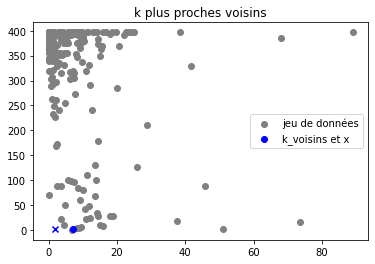

knn naive avec k = 1: --- 0.001356000000000357 seconds ---


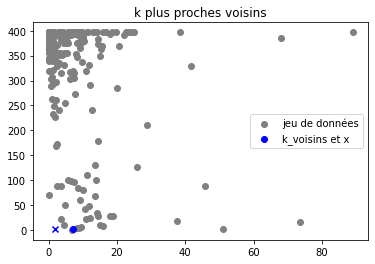

knn kdtree avec k = 10: --- 0.004241499999999121 seconds ---


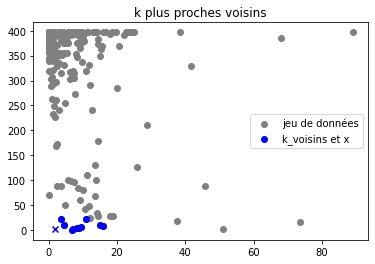

knn naive avec k = 10: --- 0.0018487999999994287 seconds ---


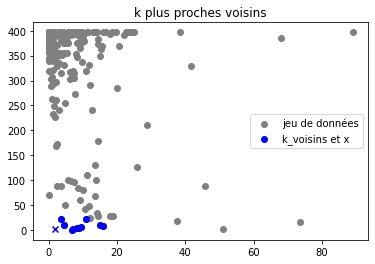

knn kdtree avec k = 50: --- 0.0043882000000010635 seconds ---


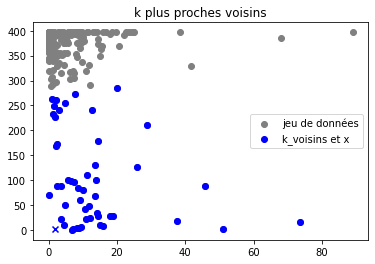

knn naive avec k = 50: --- 0.004821099999999134 seconds ---


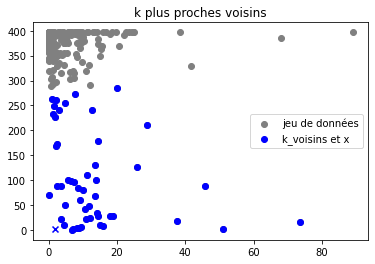

knn kdtree avec k = 100: --- 0.004690000000000083 seconds ---


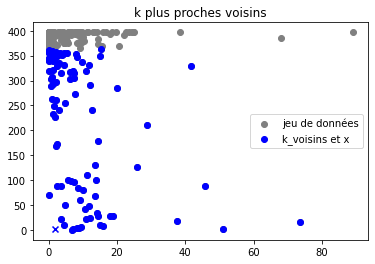

knn naive avec k = 100: --- 0.008669600000001054 seconds ---


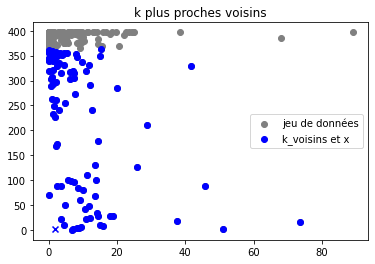

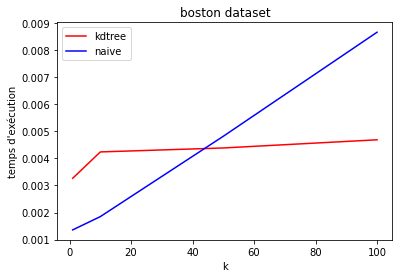



diabetes dataset-taille: 442
knn kdtree avec k = 1: --- 0.005039999999999267 seconds ---


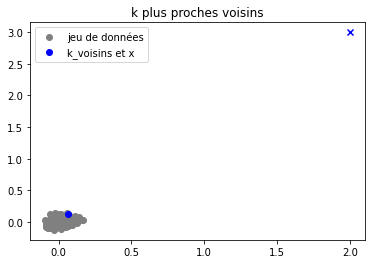

knn naive avec k = 1: --- 0.001147500000000079 seconds ---


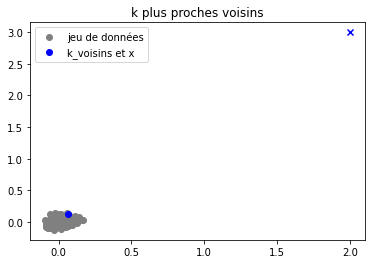

knn kdtree avec k = 10: --- 0.007803799999999583 seconds ---


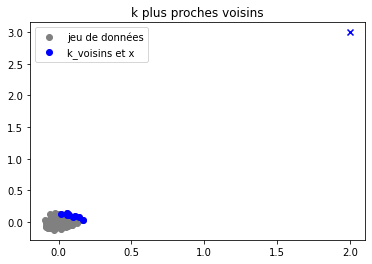

knn naive avec k = 10: --- 0.0015335999999983585 seconds ---


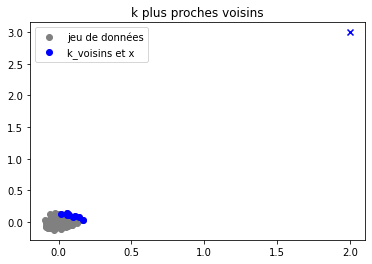

knn kdtree avec k = 50: --- 0.005479000000001122 seconds ---


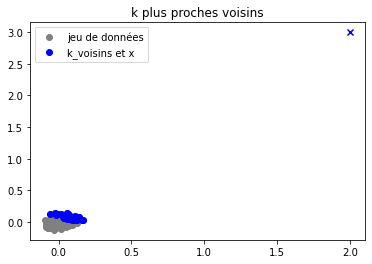

knn naive avec k = 50: --- 0.0057685999999996795 seconds ---


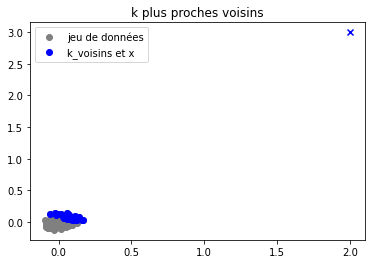

knn kdtree avec k = 100: --- 0.005644700000001279 seconds ---


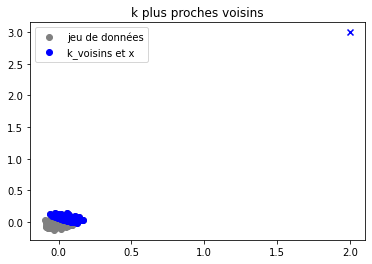

knn naive avec k = 100: --- 0.009714000000000667 seconds ---


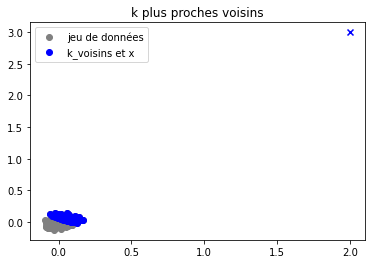

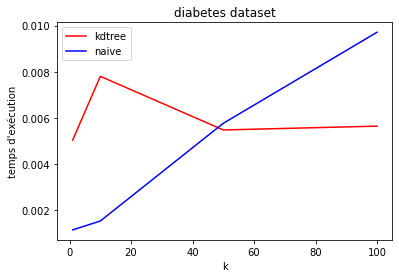



olivetti faces-taille: 400
knn kdtree avec k = 1: --- 0.004515099999998995 seconds ---


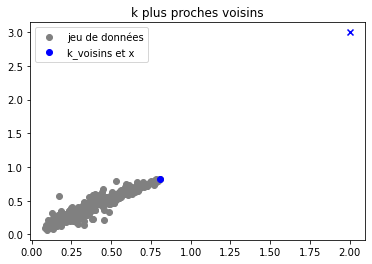

knn naive avec k = 1: --- 0.0013801999999998316 seconds ---


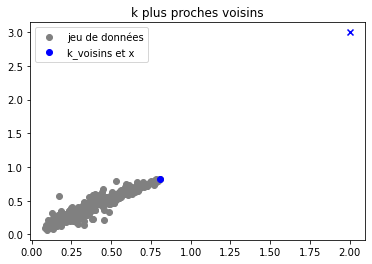

knn kdtree avec k = 10: --- 0.004863499999999021 seconds ---


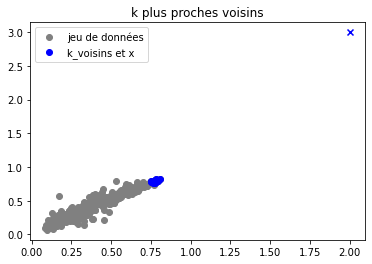

knn naive avec k = 10: --- 0.0019394999999988727 seconds ---


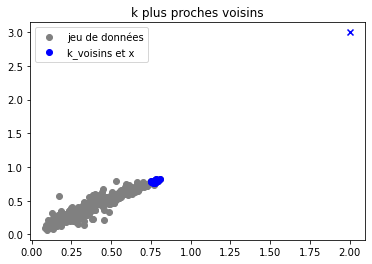

knn kdtree avec k = 50: --- 0.005627900000000352 seconds ---


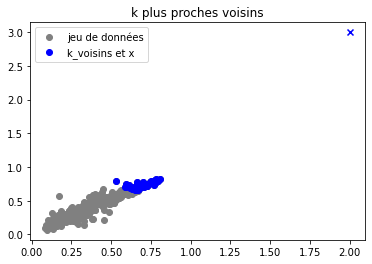

knn naive avec k = 50: --- 0.006968499999999267 seconds ---


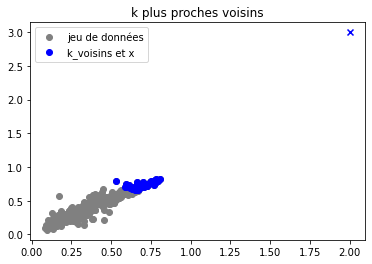

knn kdtree avec k = 100: --- 0.005253700000000805 seconds ---


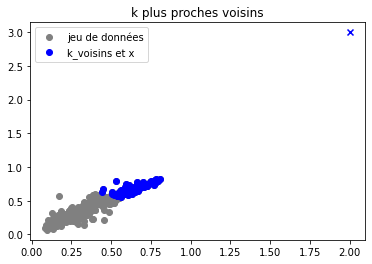

knn naive avec k = 100: --- 0.00975079999999906 seconds ---


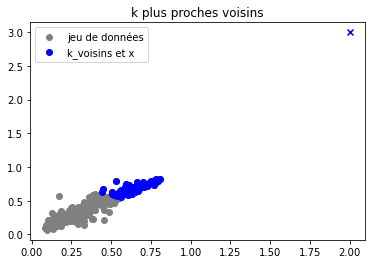

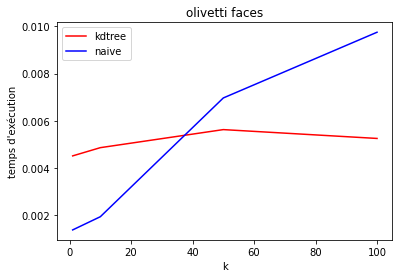

In [11]:
for dataset_name, data in all_datasets.items():
    print("\n")
    print(dataset_name + "-taille: " + str(len(data)))
    kdtree_results = []
    naive_results = []
    for k in k_list:
        
        #kd tree algorithme
        start_time_kdtree = timeit.default_timer()
        kdtree = gen_kd_tree(data)
        kdtree_knn = find_knn(kdtree, x, k)
        time_execution_kdtree = (timeit.default_timer() - start_time_kdtree)
        print("knn kdtree avec k = "+str(k)+": --- %s seconds ---" % (time_execution_kdtree))
        
        affiche(x, data, len(data), kdtree_knn, k)
        kdtree_results.append([k, time_execution_kdtree])
        
        #naive
        start_time_naive = timeit.default_timer()
        knn = cherche_k_voisins(k, x, data, len(data))
        time_execution_naive = (timeit.default_timer() - start_time_naive)
        print("knn naive avec k = "+str(k)+": --- %s seconds ---" % (time_execution_naive))
        
        affiche(x, data, len(data), knn, k)
        naive_results.append([k, time_execution_naive])
        
        
    plt.plot([x[0] for x in kdtree_results], [x[1] for x in kdtree_results], color='red', label='kdtree') 
    plt.plot([x[0] for x in naive_results], [x[1] for x in naive_results], color='b', label='naive') 
    plt.legend()
    plt.xlabel('k')
    plt.ylabel("temps d'exécution")
    plt.title(dataset_name)
    plt.show()

    

En conclusion, nous constatons qu'effectivement, plus le k est grand plus l'algorithme de kd_tree est avantageux. 